In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import tifffile
import matplotlib.pyplot as plt

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline
import cupy

cupy.cuda.Device(3)

<CUDA Device 3>

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2048  # object size in each dimension
ntheta = 1  # number of angles (rotations)

pn = 64  # tomography chunk size for GPU processing
ptheta = 1  # holography chunk size for GPU processing

center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n  # object voxel size
energy = 17.05  # [keV] xray energy
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy
focusToDetectorDistance = 1.28
ndist = 3
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
# z1[:] = z1[0]
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = 270e-3# positions of the probe and code for reconstruction
z2p = z1-z1p
# magnification when propagating from the probe plane to the detector
magnificationsp = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distancesp = (z1p*z2p)/z1

norm_magnificationsp = magnificationsp/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distancesp = distancesp*norm_magnificationsp**2
distancesp = distancesp*(z1p/z1)**2

print(distances, distancesp)
print(distances+ distancesp)


[0.00420013 0.00402658 0.0034558 ] [-0.00414823 -0.00397468 -0.00340391]
[5.18963367e-05 5.18963367e-05 5.18963367e-05]


## Read data

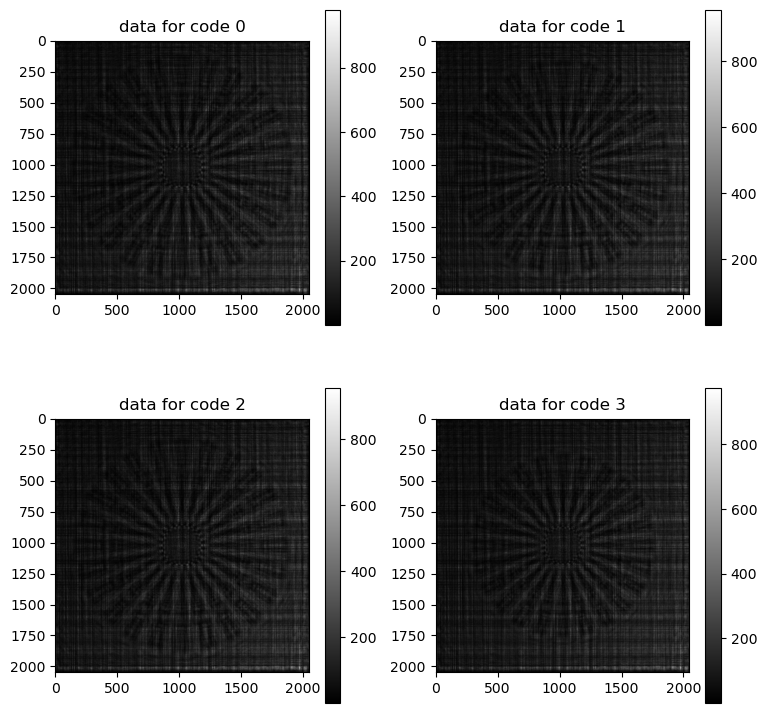

In [3]:
data = np.zeros([ndist,ntheta,n,n],dtype='float32')
for k in range(ndist):
    data[k] = dxchange.read_tiff(f'data/modeling/data_siemens_dist_{n}_{k}.tiff')
ref = dxchange.read_tiff(f'data/modeling/ref_siemens_dist_{n}_0')

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
axs[0,0].set_title('data for code 0')
fig.colorbar(im)
im=axs[0,1].imshow(data[1,0],cmap='gray')
axs[0,1].set_title('data for code 1')
fig.colorbar(im)
im=axs[1,0].imshow(data[-2,0],cmap='gray')
axs[1,0].set_title('data for code 2')
fig.colorbar(im)
im=axs[1,1].imshow(data[-1,0],cmap='gray')
axs[1,1].set_title('data for code 3')
fig.colorbar(im)

## Read the probe

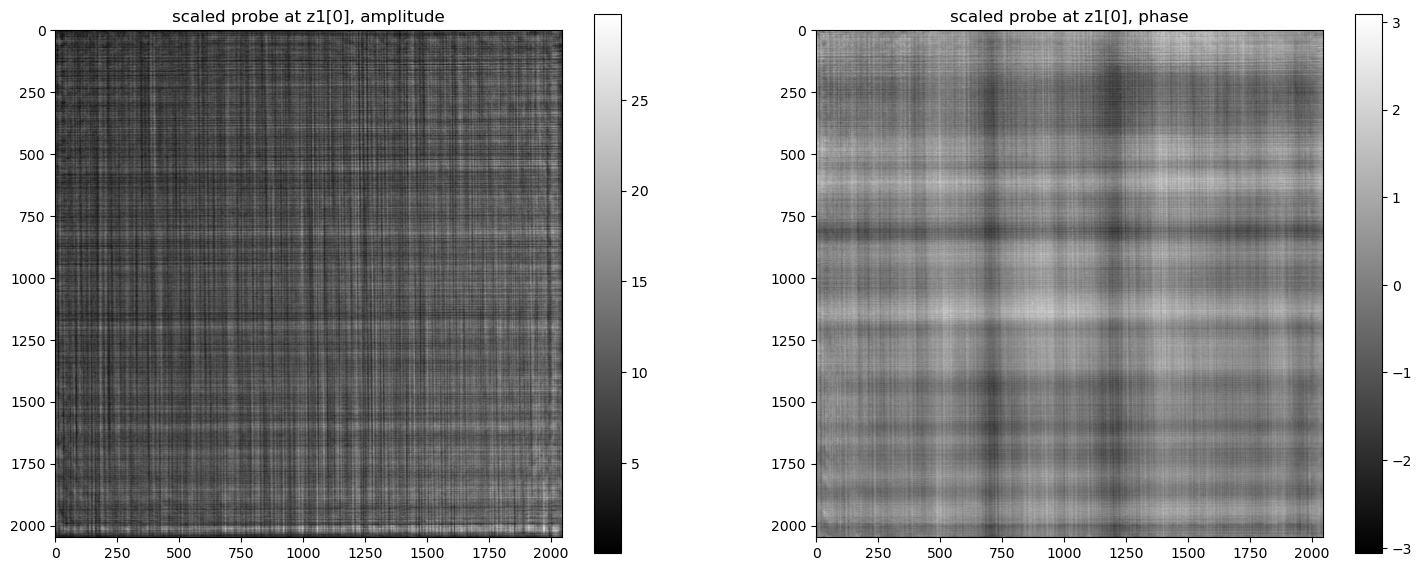

In [4]:
prb = np.ones([1,n,n],dtype='complex64')
prb[:] = (tifffile.imread(f'data/prb_id16a/prb_abs_{n}.tiff')*np.exp(1j* tifffile.imread(f'data/prb_id16a/prb_phase_{n}.tiff')))[0]
# prb[:] = 1
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('scaled probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('scaled probe at z1[0], phase')
fig.colorbar(im)

## Create a solver class for holography, note the class has additional parameters distances2 to be able to compute Fresnel propagation between the sample and probe

In [5]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications, distancesp)
pslv0 = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances[:1], norm_magnifications[:1], distancesp[:1]) 


# Read codes

In [6]:
shifts = np.load('shifts.npy')

## Conjugate gradient solver

In [7]:
import cupy as cp

def line_search(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma


def cg_holo(pslv, pslv0, data, data_ref, init, init_prb,  piter,shifts, codes, shifts_code, upd_psi=True, upd_prb=False,step=1,vis_step=1):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(fpsi,fprb):
        f = cp.linalg.norm(cp.abs(fpsi)-cp.sqrt(data))**2            
        # f += cp.linalg.norm(cp.abs(fprb)-cp.sqrt(data_ref))**2        
        # f = cp.linalg.norm(cp.abs(fpsi)**2-data)**2            
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = 1
    gammaprb = 1
    conv = np.zeros(piter//step)
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts,codes,shifts_code)          
            grad = pslv.adj_holo(fpsi-cp.sqrt(data)*cp.exp(1j*(cp.angle(fpsi))), prb,shifts,codes,shifts_code)/cp.max(cp.abs(prb))**2#/ndist**2
            # d = -grad    
            # Dai-Yuan direction
            if i == 0:
                d = -grad
            else:
                d = -grad+cp.linalg.norm(grad)**2 / \
                    ((cp.sum(cp.conj(d)*(grad-grad0))))*d
            grad0 = grad
            # line search
            fd = pslv.fwd_holo(d, prb,shifts,codes,shifts_code)          
            gammapsi = line_search(minf, 1, fpsi, 0, fd, 0)
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts,codes,shifts_code)          
            fprb0 = pslv0.fwd_holo(psi*0+1,prb,shifts*0,codes,shifts_code)       
            
            gradprb = pslv.adj_holo_prb(fprb-cp.sqrt(data)*cp.exp(1j*cp.angle(fprb)),psi,shifts,codes,shifts_code)/cp.max(cp.abs(psi))**2/pslv.ntheta#/ndist**2
            gradprb += pslv0.adj_holo_prb(fprb0-cp.sqrt(data_ref)*cp.exp(1j*cp.angle(fprb0)),psi*0+1,shifts*0,codes,shifts_code)       
            gradprb*=0.5
            dprb = -gradprb
            # gradprb0 = gradprb
            # line search
            fdprb = pslv.fwd_holo(psi, dprb,shifts,codes,shifts_code)       
            fdprb0 = pslv0.fwd_holo(psi*0+1, dprb,shifts*0,codes,shifts_code)       
            
            gammaprb = line_search(minf, 1, fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        if i%step==0:
            fprb = pslv.fwd_holo(psi,prb,shifts,codes,shifts_code)       
            fprb0 = pslv0.fwd_holo(psi*0+1,prb,shifts*0,codes,shifts_code)                   
            err=minf(fprb,fprb0)
            conv[i//step]=err
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}')  
    
        if i%vis_step==0:  
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(np.abs(psi[0,n//2:3*n//2,n//2:3*n//2].get()),cmap='gray')
            axs[0].set_title('reconstructed amplitude')
            fig.colorbar(im)
            im=axs[1].imshow(np.angle(psi[0,n//2:3*n//2,n//2:3*n//2].get()),cmap='gray')
            axs[1].set_title('reconstructed phase')
            fig.colorbar(im)
            
            plt.show()
        
    return psi,prb,conv

def cg_holo_batch(pslv, pslv0, data,data_ref, init, prb_init, piter,shifts=None,codes=None,shifts_code=None,upd_psi=True,upd_prb=False,step=1,vis_step=1):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, 2*pslv.n, 2*pslv.n], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)       
             
    codes_gpu = None
    data_ref_gpu = None

        
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])        
        init_gpu = cp.array(init[ids])
        shifts_gpu = cp.array(shifts[:,ids])
        shifts_code_gpu = None#cp.array(shifts_code[:,ids])
            
        # Radon transform
        res_gpu,res_prb_gpu,conv = cg_holo(pslv, pslv0, data_gpu,data_ref_gpu, init_gpu,prb_init_gpu, piter,
                                      shifts_gpu,codes_gpu, shifts_code_gpu, upd_psi, upd_prb,step,vis_step)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb,conv




0) gammapsi=1 gammaprb=1, err=1.18617e+07


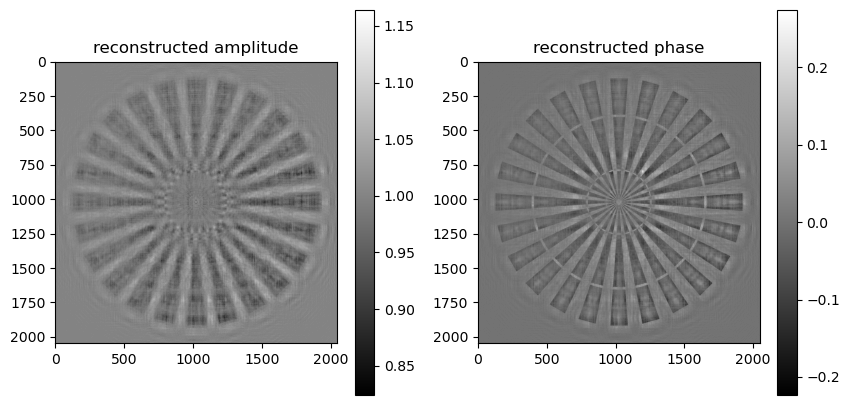

1) gammapsi=1 gammaprb=1, err=3.36735e+06
2) gammapsi=1 gammaprb=1, err=2.56484e+06
3) gammapsi=1 gammaprb=1, err=1.54798e+06
4) gammapsi=1 gammaprb=1, err=1.33494e+06
5) gammapsi=1 gammaprb=1, err=9.80126e+05
6) gammapsi=1 gammaprb=1, err=8.71510e+05
7) gammapsi=1 gammaprb=1, err=6.89051e+05
8) gammapsi=1 gammaprb=1, err=6.16387e+05
9) gammapsi=1 gammaprb=1, err=5.28276e+05
10) gammapsi=1 gammaprb=1, err=4.71481e+05
11) gammapsi=1 gammaprb=1, err=4.17782e+05
12) gammapsi=1 gammaprb=1, err=3.77879e+05
13) gammapsi=1 gammaprb=1, err=3.34937e+05
14) gammapsi=1 gammaprb=1, err=3.04674e+05
15) gammapsi=1 gammaprb=1, err=2.73696e+05
16) gammapsi=1 gammaprb=1, err=2.49902e+05
17) gammapsi=1 gammaprb=1, err=2.24195e+05
18) gammapsi=1 gammaprb=1, err=2.06358e+05
19) gammapsi=1 gammaprb=1, err=1.86528e+05
20) gammapsi=1 gammaprb=1, err=1.71849e+05
21) gammapsi=1 gammaprb=1, err=1.57445e+05
22) gammapsi=1 gammaprb=1, err=1.45492e+05
23) gammapsi=1 gammaprb=1, err=1.35741e+05
24) gammapsi=1 gamma

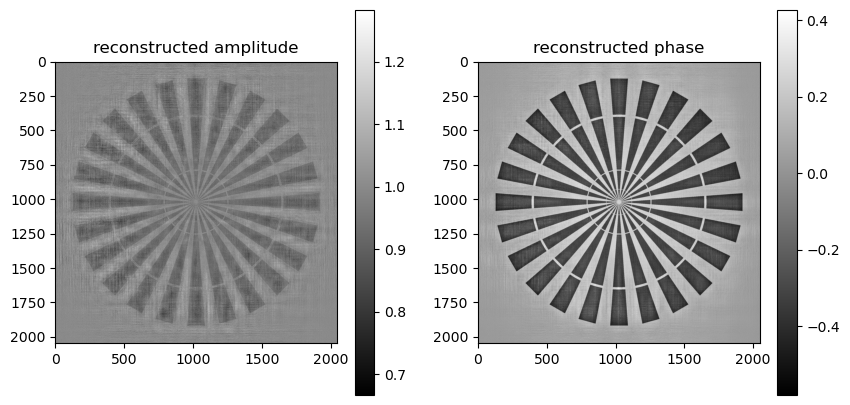

33) gammapsi=1 gammaprb=1, err=7.83474e+04
34) gammapsi=1 gammaprb=1, err=7.61866e+04
35) gammapsi=1 gammaprb=1, err=7.38257e+04
36) gammapsi=1 gammaprb=1, err=7.17195e+04
37) gammapsi=1 gammaprb=1, err=7.01520e+04
38) gammapsi=1 gammaprb=1, err=6.80539e+04
39) gammapsi=1 gammaprb=1, err=6.66729e+04
40) gammapsi=1 gammaprb=1, err=6.53537e+04
41) gammapsi=1 gammaprb=1, err=6.32319e+04
42) gammapsi=1 gammaprb=1, err=6.22687e+04
43) gammapsi=0.5 gammaprb=1, err=6.10515e+04
44) gammapsi=1 gammaprb=1, err=5.97169e+04
45) gammapsi=1 gammaprb=1, err=5.88119e+04
46) gammapsi=1 gammaprb=1, err=5.59830e+04
47) gammapsi=1 gammaprb=1, err=5.51476e+04
48) gammapsi=1 gammaprb=1, err=5.17748e+04
49) gammapsi=1 gammaprb=1, err=4.98085e+04
50) gammapsi=1 gammaprb=1, err=4.83204e+04
51) gammapsi=1 gammaprb=1, err=4.69491e+04
52) gammapsi=1 gammaprb=1, err=4.57813e+04
53) gammapsi=1 gammaprb=1, err=4.45755e+04
54) gammapsi=1 gammaprb=1, err=4.22413e+04
55) gammapsi=1 gammaprb=1, err=4.10944e+04
56) gamma

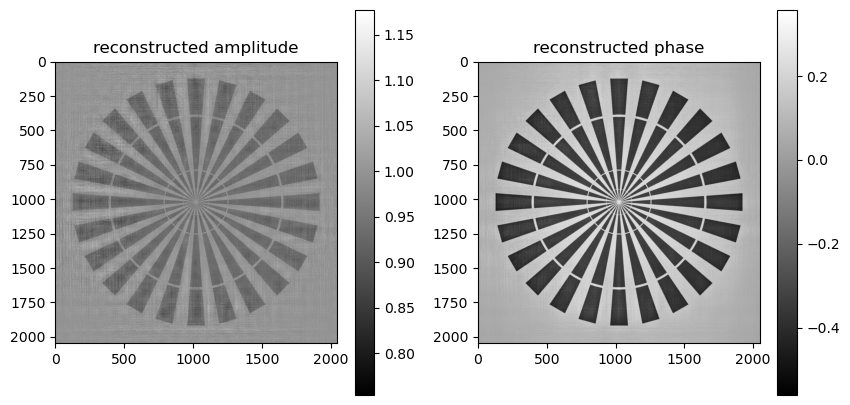

65) gammapsi=1 gammaprb=1, err=2.76998e+04
66) gammapsi=1 gammaprb=1, err=2.72338e+04
67) gammapsi=1 gammaprb=1, err=2.66969e+04
68) gammapsi=1 gammaprb=1, err=2.63056e+04
69) gammapsi=1 gammaprb=1, err=2.57445e+04
70) gammapsi=1 gammaprb=1, err=2.51341e+04
71) gammapsi=0.5 gammaprb=1, err=2.49175e+04
72) gammapsi=1 gammaprb=1, err=2.40818e+04
73) gammapsi=1 gammaprb=1, err=2.36989e+04
74) gammapsi=1 gammaprb=1, err=2.31390e+04
75) gammapsi=1 gammaprb=1, err=2.25066e+04
76) gammapsi=1 gammaprb=1, err=2.22770e+04
77) gammapsi=1 gammaprb=1, err=2.16746e+04
78) gammapsi=1 gammaprb=1, err=2.13627e+04
79) gammapsi=1 gammaprb=1, err=2.06048e+04
80) gammapsi=1 gammaprb=1, err=2.03344e+04
81) gammapsi=1 gammaprb=1, err=1.99613e+04
82) gammapsi=1 gammaprb=1, err=1.97210e+04
83) gammapsi=1 gammaprb=1, err=1.94608e+04
84) gammapsi=1 gammaprb=1, err=1.91546e+04
85) gammapsi=1 gammaprb=1, err=1.89047e+04
86) gammapsi=1 gammaprb=1, err=1.87076e+04
87) gammapsi=1 gammaprb=1, err=1.84934e+04
88) gamma

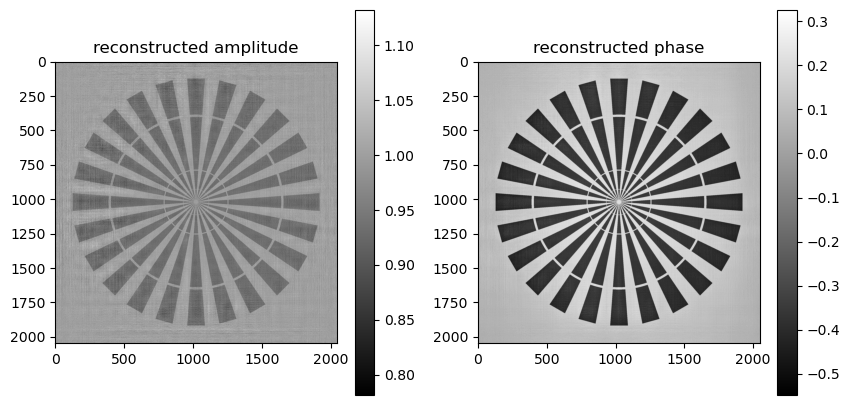

97) gammapsi=1 gammaprb=1, err=1.68245e+04
98) gammapsi=1 gammaprb=1, err=1.66978e+04
99) gammapsi=0.5 gammaprb=1, err=1.64506e+04
100) gammapsi=1 gammaprb=1, err=1.63024e+04
101) gammapsi=1 gammaprb=1, err=1.60885e+04
102) gammapsi=1 gammaprb=1, err=1.58322e+04
103) gammapsi=1 gammaprb=1, err=1.57410e+04
104) gammapsi=1 gammaprb=1, err=1.54701e+04
105) gammapsi=1 gammaprb=1, err=1.53282e+04
106) gammapsi=1 gammaprb=1, err=1.50372e+04
107) gammapsi=1 gammaprb=1, err=1.49277e+04
108) gammapsi=1 gammaprb=1, err=1.47652e+04
109) gammapsi=1 gammaprb=1, err=1.45810e+04
110) gammapsi=1 gammaprb=1, err=1.44784e+04
111) gammapsi=1 gammaprb=1, err=1.43322e+04
112) gammapsi=1 gammaprb=1, err=1.41883e+04
113) gammapsi=1 gammaprb=1, err=1.40794e+04
114) gammapsi=1 gammaprb=1, err=1.38545e+04
115) gammapsi=1 gammaprb=1, err=1.37458e+04
116) gammapsi=1 gammaprb=1, err=1.36213e+04
117) gammapsi=1 gammaprb=1, err=1.34091e+04
118) gammapsi=1 gammaprb=1, err=1.32996e+04
119) gammapsi=1 gammaprb=1, err=1

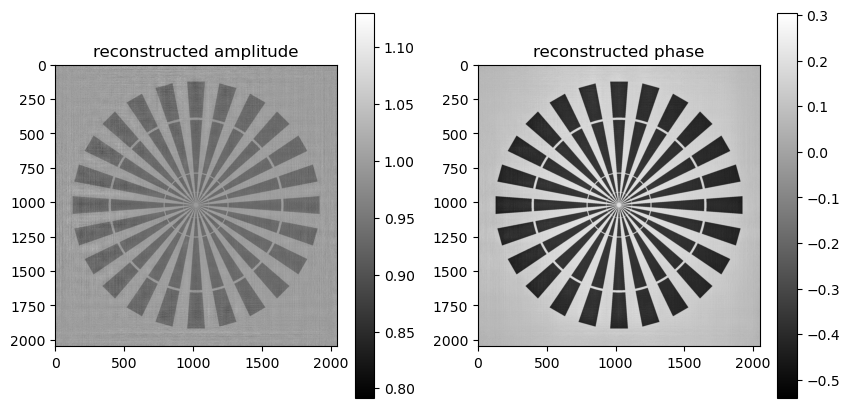

129) gammapsi=0.25 gammaprb=1, err=1.17090e+04
130) gammapsi=1 gammaprb=1, err=1.14419e+04
131) gammapsi=1 gammaprb=1, err=1.12163e+04
132) gammapsi=1 gammaprb=1, err=1.11829e+04
133) gammapsi=1 gammaprb=1, err=1.09920e+04
134) gammapsi=1 gammaprb=1, err=1.09224e+04
135) gammapsi=1 gammaprb=1, err=1.06034e+04
136) gammapsi=1 gammaprb=1, err=1.05085e+04
137) gammapsi=1 gammaprb=1, err=1.04074e+04
138) gammapsi=1 gammaprb=1, err=1.02972e+04
139) gammapsi=1 gammaprb=1, err=1.00936e+04
140) gammapsi=1 gammaprb=1, err=9.87432e+03
141) gammapsi=1 gammaprb=1, err=9.78439e+03
142) gammapsi=1 gammaprb=1, err=9.69136e+03
143) gammapsi=1 gammaprb=1, err=9.60985e+03
144) gammapsi=1 gammaprb=1, err=9.44883e+03
145) gammapsi=1 gammaprb=1, err=9.31806e+03
146) gammapsi=1 gammaprb=1, err=9.20362e+03
147) gammapsi=1 gammaprb=1, err=9.10321e+03
148) gammapsi=1 gammaprb=1, err=9.02548e+03
149) gammapsi=1 gammaprb=1, err=8.95764e+03
150) gammapsi=1 gammaprb=1, err=8.87593e+03
151) gammapsi=1 gammaprb=1, e

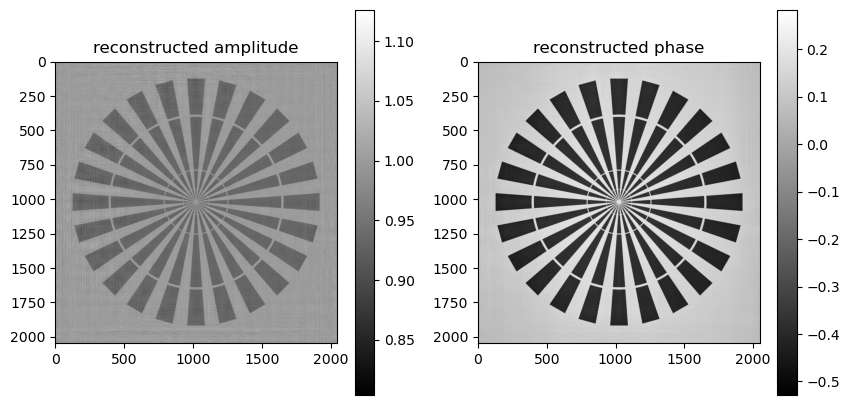

161) gammapsi=1 gammaprb=1, err=8.24628e+03
162) gammapsi=1 gammaprb=1, err=8.07950e+03
163) gammapsi=1 gammaprb=1, err=7.63543e+03
164) gammapsi=1 gammaprb=1, err=7.50170e+03
165) gammapsi=1 gammaprb=1, err=7.43090e+03
166) gammapsi=1 gammaprb=1, err=7.38577e+03
167) gammapsi=1 gammaprb=1, err=7.32928e+03
168) gammapsi=1 gammaprb=1, err=7.23824e+03
169) gammapsi=1 gammaprb=1, err=7.20314e+03
170) gammapsi=1 gammaprb=1, err=7.09461e+03
171) gammapsi=1 gammaprb=1, err=7.02036e+03
172) gammapsi=1 gammaprb=1, err=6.96976e+03
173) gammapsi=1 gammaprb=1, err=6.91648e+03
174) gammapsi=1 gammaprb=1, err=6.85965e+03
175) gammapsi=1 gammaprb=1, err=6.81274e+03
176) gammapsi=1 gammaprb=1, err=6.75587e+03
177) gammapsi=1 gammaprb=1, err=6.71872e+03
178) gammapsi=1 gammaprb=1, err=6.64373e+03
179) gammapsi=1 gammaprb=1, err=6.61283e+03
180) gammapsi=1 gammaprb=1, err=6.56604e+03
181) gammapsi=1 gammaprb=1, err=6.51644e+03
182) gammapsi=1 gammaprb=1, err=6.48574e+03
183) gammapsi=1 gammaprb=1, err=

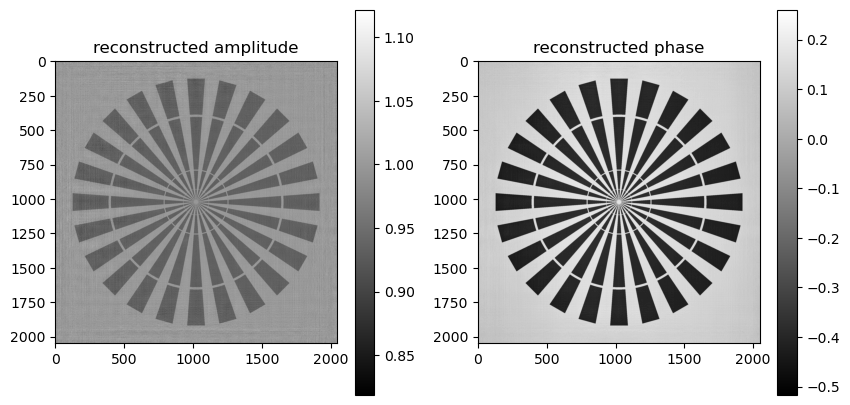

193) gammapsi=1 gammaprb=1, err=5.96772e+03
194) gammapsi=1 gammaprb=1, err=5.93237e+03
195) gammapsi=1 gammaprb=1, err=5.90334e+03
196) gammapsi=1 gammaprb=1, err=5.86941e+03
197) gammapsi=1 gammaprb=1, err=5.84104e+03
198) gammapsi=1 gammaprb=1, err=5.81241e+03
199) gammapsi=1 gammaprb=1, err=5.78305e+03
200) gammapsi=1 gammaprb=1, err=5.75800e+03
201) gammapsi=1 gammaprb=1, err=5.72701e+03
202) gammapsi=1 gammaprb=1, err=5.70352e+03
203) gammapsi=1 gammaprb=1, err=5.67943e+03
204) gammapsi=1 gammaprb=1, err=5.65033e+03
205) gammapsi=1 gammaprb=1, err=5.63276e+03
206) gammapsi=1 gammaprb=1, err=5.58765e+03
207) gammapsi=1 gammaprb=1, err=5.56890e+03
208) gammapsi=0.5 gammaprb=1, err=5.55089e+03
209) gammapsi=1 gammaprb=1, err=5.53021e+03
210) gammapsi=0.5 gammaprb=1, err=5.50811e+03
211) gammapsi=1 gammaprb=1, err=5.43430e+03
212) gammapsi=1 gammaprb=1, err=5.40298e+03
213) gammapsi=0.25 gammaprb=1, err=5.39976e+03
214) gammapsi=1 gammaprb=1, err=5.33580e+03
215) gammapsi=1 gammaprb=

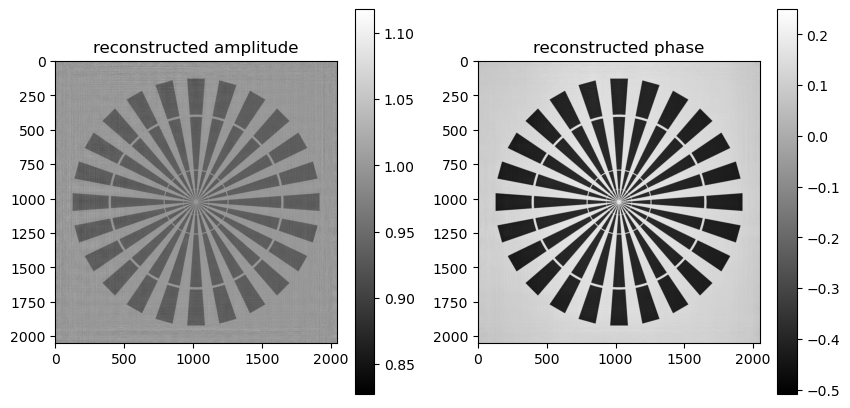

225) gammapsi=1 gammaprb=1, err=4.93200e+03
226) gammapsi=1 gammaprb=1, err=4.90484e+03
227) gammapsi=1 gammaprb=1, err=4.88190e+03
228) gammapsi=1 gammaprb=1, err=4.86053e+03
229) gammapsi=1 gammaprb=1, err=4.83291e+03
230) gammapsi=1 gammaprb=1, err=4.81541e+03
231) gammapsi=1 gammaprb=1, err=4.78887e+03
232) gammapsi=1 gammaprb=1, err=4.76891e+03
233) gammapsi=1 gammaprb=1, err=4.75603e+03
234) gammapsi=1 gammaprb=1, err=4.71438e+03
235) gammapsi=1 gammaprb=1, err=4.69692e+03
236) gammapsi=0.5 gammaprb=1, err=4.66242e+03
237) gammapsi=1 gammaprb=1, err=4.59930e+03
238) gammapsi=1 gammaprb=1, err=4.55909e+03
239) gammapsi=1 gammaprb=1, err=4.54312e+03
240) gammapsi=1 gammaprb=1, err=4.49090e+03
241) gammapsi=1 gammaprb=1, err=4.46310e+03
242) gammapsi=1 gammaprb=1, err=4.43401e+03
243) gammapsi=1 gammaprb=1, err=4.41288e+03
244) gammapsi=1 gammaprb=1, err=4.37797e+03
245) gammapsi=1 gammaprb=1, err=4.35909e+03
246) gammapsi=1 gammaprb=1, err=4.33181e+03
247) gammapsi=1 gammaprb=1, er

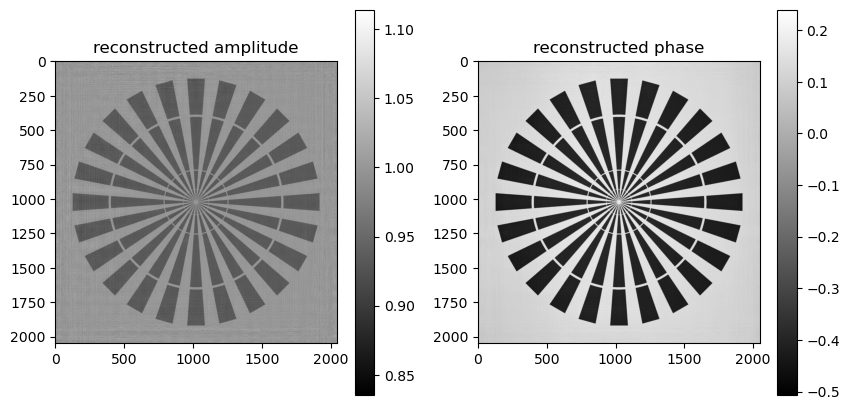

In [8]:
shifts_rec = cp.array(shifts/norm_magnifications[:,np.newaxis,np.newaxis])
rec = np.ones([ntheta,2*n,2*n],dtype='complex64')

# use only the abs value of the probe as initial guess
rec_prb = prb
data_ref = ref
codes = None
shifts_code=None
rec,rec_prb,conv = cg_holo_batch(pslv, pslv0, data, data_ref, rec, rec_prb, 257, shifts_rec, codes, shifts_code, True,False,1,32)


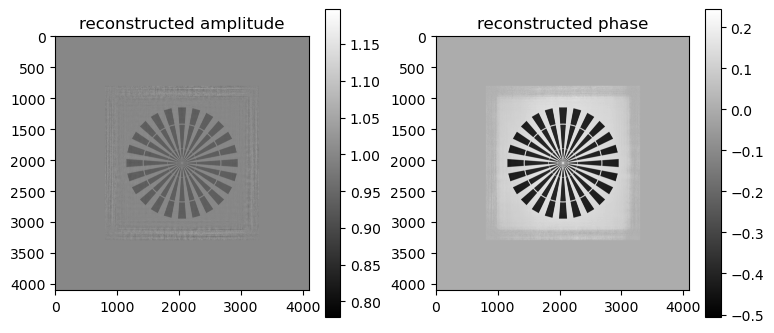

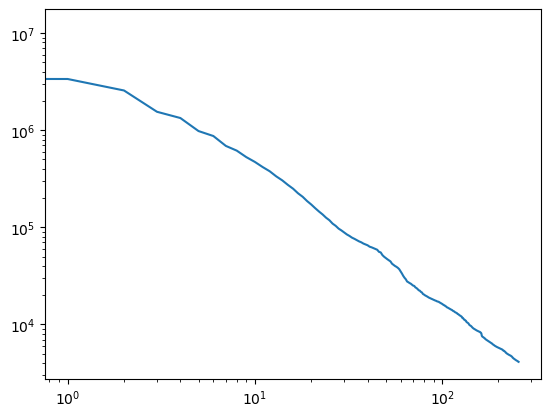

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(rec[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[0]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)
plt.figure()
plt.loglog(conv)

dxchange.write_tiff(np.angle(rec[0]),f'data/modeling/rec_siemens_dist_{n}_0',overwrite=True)
np.save(f'data/modeling/conv_siemens_dist_{n}_0',conv)

